In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

import pandas as pd
import os
import json
import matplotlib.pyplot as plt
import numpy as np

from feature_extraction import get_autoregression_features, get_autoregression_targets, make_train_test_split

plt.rcParams["font.size"] = 16
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"

np.random.seed(42)

def read_kaggle_json(filepath):
    filepath = os.path.expanduser(filepath)
    username = None
    token = None
    with open(filepath, "r") as file:
        config = json.load(file)
        username = config.get("username")
        token = config.get("key")
    return username, token


kaggle_json_filepath = "/workspaces/fall-2024-class-08/kaggle/kaggle.json"
kaggle_username, kaggle_api_token = read_kaggle_json(kaggle_json_filepath)

if kaggle_username and kaggle_api_token:
    os.environ["KAGGLE_USERNAME"] = kaggle_username
    os.environ["KAGGLE_KEY"] = kaggle_api_token

import kaggle

dataset_name = "andrewmvd/sp-500-stocks"
download_location = "/workspaces/fall-2024-class-08/downloads"

kaggle.api.authenticate()
kaggle.api.dataset_download_files(
    dataset_name, path=download_location, unzip=True
)

Dataset URL: https://www.kaggle.com/datasets/andrewmvd/sp-500-stocks


In [2]:
stocks_file_path = "/workspaces/fall-2024-class-08/downloads/sp500_stocks.csv"
index_file_path = "/workspaces/fall-2024-class-08/downloads/sp500_index.csv"
companies_file_path = (
    "/workspaces/fall-2024-class-08/downloads/sp500_companies.csv"
)

stocks_df = pd.read_csv(stocks_file_path)
index_df = pd.read_csv(index_file_path)
companies_df = pd.read_csv(companies_file_path)
dates = stocks_df["Date"].unique()

technology_symbols_sorted_by_marketcap = companies_df[
    companies_df["Sector"] == "Technology"
].sort_values(by="Marketcap", ascending=False)["Symbol"]

top_ten_technology_symbols = technology_symbols_sorted_by_marketcap[:10]

print(top_ten_technology_symbols)

0     AAPL
1     NVDA
2     MSFT
9     AVGO
16    ORCL
26     CRM
30     AMD
34    CSCO
35     ACN
36    ADBE
Name: Symbol, dtype: object


In [3]:
# Specify the target symbol to predict, number of days of history to use in the
# autoregressive model, and number of days forward to predict.
target_symbol = "AAPL"
n_days_history = 20
n_days_forward = 1

# Specify the list of symbols to use as features. To use the top ten tech
# stocks by market cap, use the following:
# >>> predictor_symbols = top_ten_technology_symbols.tolist()
predictor_symbols = ["AAPL"]

# Get the dataset
x_features = get_autoregression_features(
    dates, stocks_df, n_days_history, n_days_forward, predictor_symbols
)
inference_dates, y_targets_low, y_targets_high = get_autoregression_targets(
    dates, stocks_df, target_symbol, n_days_history, n_days_forward
)

# Train-test split
dates_train, dates_test = make_train_test_split(inference_dates)
x_train, x_test = make_train_test_split(x_features)
y_low_train, y_low_test = make_train_test_split(y_targets_low)
y_high_train, y_high_test = make_train_test_split(y_targets_high)

In [4]:
from sklearn.neural_network import MLPRegressor
from error_metrics import compute_mae_pair
from regressors import predict_mlp_regressor_pair

In [5]:
low_model = MLPRegressor(
    hidden_layer_sizes=(100, 100, 100),
    random_state=42,
    max_iter=500,
    tol=0.00001,
    solver="adam",
    learning_rate="adaptive",
    learning_rate_init=0.0001,
    verbose=True,
)
high_model = MLPRegressor(
    hidden_layer_sizes=(100, 100, 100),
    random_state=42,
    max_iter=500,
    tol=0.00001,
    solver="adam",
    learning_rate="adaptive",
    learning_rate_init=0.0001,
    verbose=False,
)
low_model.fit(x_train, y_low_train)
high_model.fit(x_train, y_high_train)

y_low_train_hat, y_high_train_hat = predict_mlp_regressor_pair(
    low_model, high_model, x_train
)
low_rmse_train, high_rmse_train = compute_mae_pair(
    y_low_train, y_high_train, y_low_train_hat, y_high_train_hat
)

print("Training MAE for low value prediction:", low_rmse_train)
print("Training MAE for high value prediction:", high_rmse_train)

Iteration 1, loss = 852.95953480
Iteration 2, loss = 145.83189371
Iteration 3, loss = 8.62987467
Iteration 4, loss = 9.01621715
Iteration 5, loss = 4.95473089
Iteration 6, loss = 4.45343260
Iteration 7, loss = 4.16365013
Iteration 8, loss = 3.84870998
Iteration 9, loss = 3.60302391
Iteration 10, loss = 3.41285675
Iteration 11, loss = 3.22703771
Iteration 12, loss = 3.06833457
Iteration 13, loss = 2.88584350
Iteration 14, loss = 2.73126100
Iteration 15, loss = 2.61513751
Iteration 16, loss = 2.49657396
Iteration 17, loss = 2.40080508
Iteration 18, loss = 2.32085755
Iteration 19, loss = 2.22558761
Iteration 20, loss = 2.12390106
Iteration 21, loss = 2.04834643
Iteration 22, loss = 1.97276894
Iteration 23, loss = 1.90410978
Iteration 24, loss = 1.83940179
Iteration 25, loss = 1.78525724
Iteration 26, loss = 1.73563582
Iteration 27, loss = 1.64454414
Iteration 28, loss = 1.60162566
Iteration 29, loss = 1.53626252
Iteration 30, loss = 1.49109692
Iteration 31, loss = 1.46870783
Iteration 32,

In [6]:
y_low_test_hat, y_high_test_hat = predict_mlp_regressor_pair(
    low_model, high_model, x_test
)
low_mse_test, high_mse_test = compute_mae_pair(
    y_low_test, y_high_test, y_low_test_hat, y_high_test_hat
)

print("Test MAE for low value prediction:", low_mse_test)
print("Test MAE for high value prediction:", high_mse_test)

Test MAE for low value prediction: 2.630421591241482
Test MAE for high value prediction: 2.477113219706202


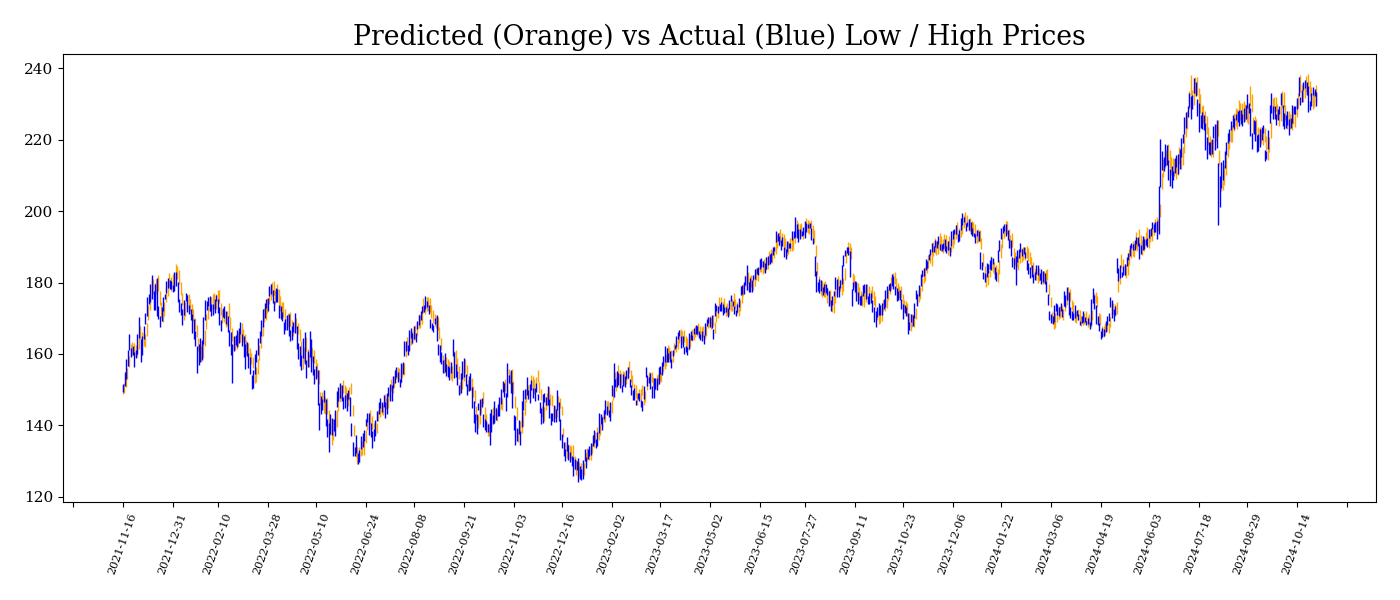

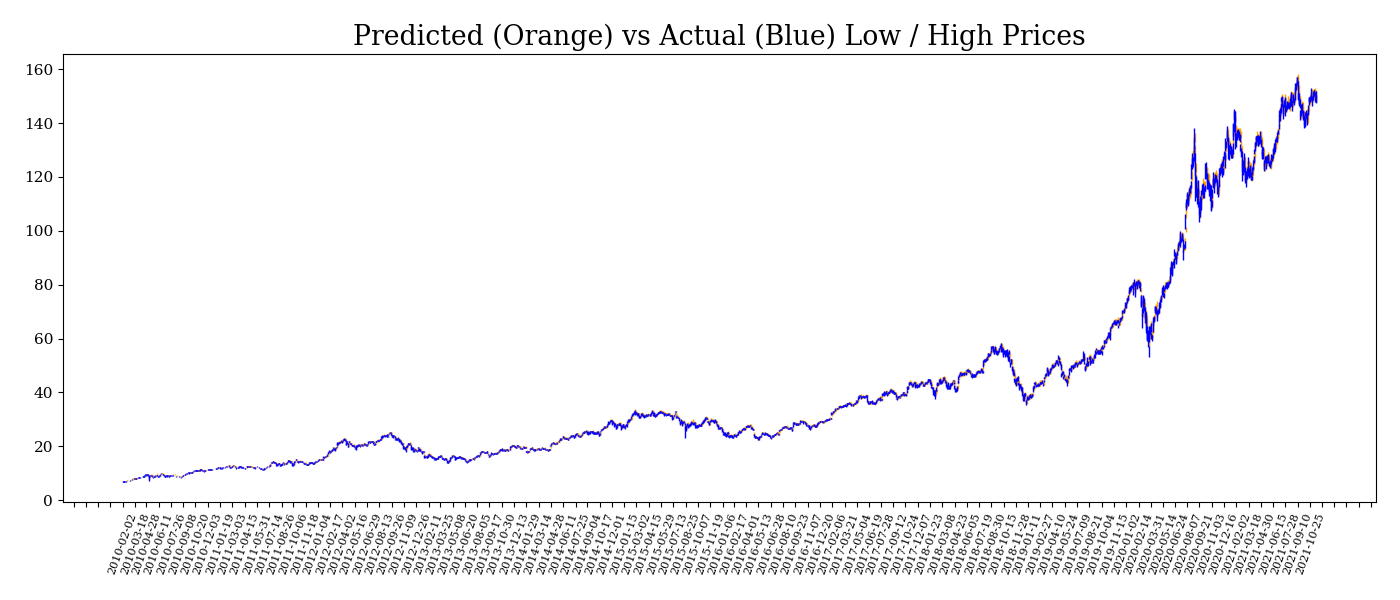

In [7]:
from visualization import plot_candlesticks

plot_candlesticks(
    dates_test, y_low_test_hat, y_high_test_hat, y_low_test, y_high_test
)
plot_candlesticks(
    dates_train, y_low_train_hat, y_high_train_hat, y_low_train, y_high_train
)

<Axes: >

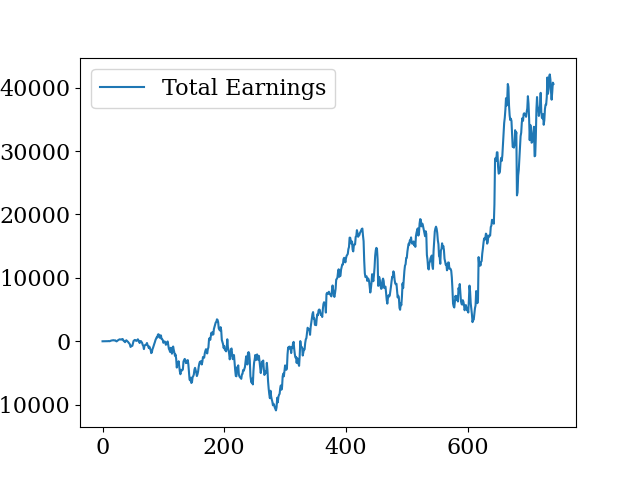

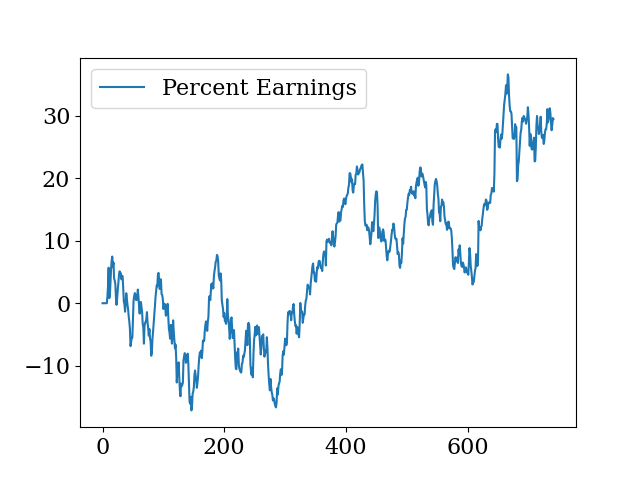

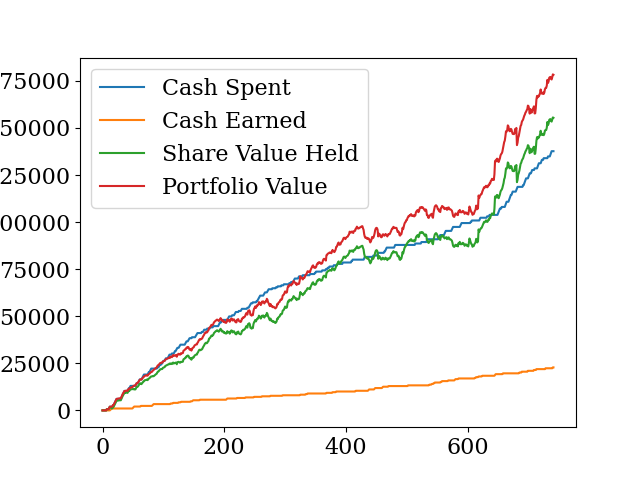

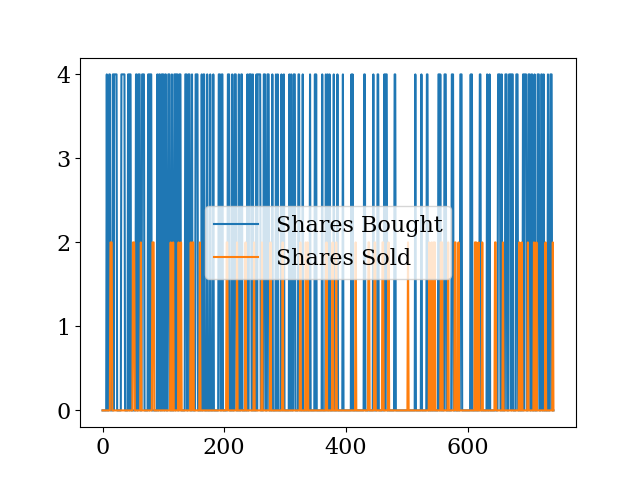

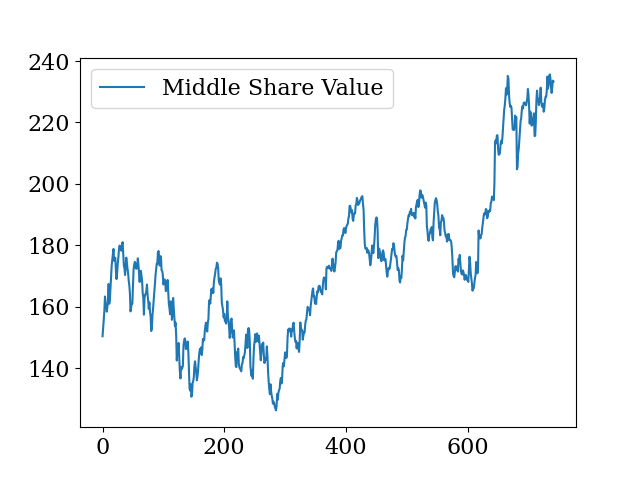

In [8]:
from trading_agent_simulator import (
    BasicTradingAlgorithmConfiguration,
    TraderState,
    run_basic_regressor_agent,
)

params = BasicTradingAlgorithmConfiguration(
    low_model=low_model,
    high_model=high_model,
    buy_shares=4,
    sell_shares=2,
    delta_buy_threshold=1.5,
    delta_sell_threshold=-1.5,
)

state = TraderState()
run_basic_regressor_agent(params, state, x_test, y_low_test, y_high_test)

trading_history_df = pd.DataFrame(state.trading_history)
trading_history_df[["Total Earnings"]].plot()
trading_history_df[["Percent Earnings"]].plot()
trading_history_df[
    ["Cash Spent", "Cash Earned", "Share Value Held", "Portfolio Value"]
].plot()
trading_history_df[["Shares Bought", "Shares Sold"]].plot()
trading_history_df[["Middle Share Value"]].plot()